# MSE 211 MDP Project

We can do the project here

# of iterations: 220
# of iterations: 220
None


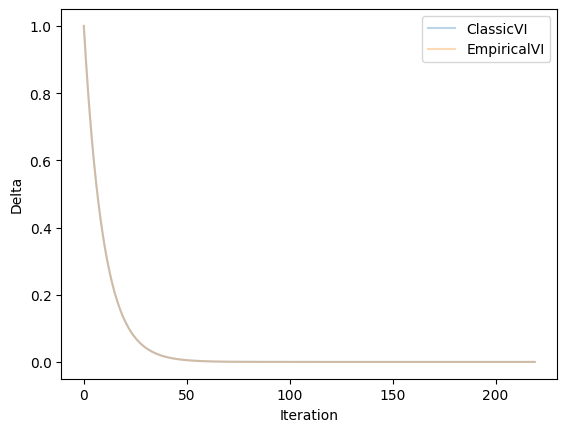

In [8]:
from value_iteration import ClassicValueIteration, RandomValueIteration, EmpiricalValueIteration, CyclicValueIteration, RandomCyclicValueIteration, VISimulation
from game import SimpleGame, GridWorld
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

algors = [ClassicValueIteration, RandomValueIteration, CyclicValueIteration, RandomCyclicValueIteration]
max_iter = 300
theta = 1e-10

m = ClassicValueIteration(GridWorld(5))
v = VISimulation(m)
v.simulate(max_iter, theta)

m = EmpiricalValueIteration(GridWorld(5))
v = VISimulation(m)
res = v.simulate(max_iter, theta)
print(res)

# m = RandomValueIteration(GridWorld(5), sample_rate=0.4)
# VISimulation(m, Counter()).simulate(max_iter, theta)

# m = CyclicValueIteration(GridWorld(5))
# VISimulation(m).simulate(max_itæer, theta)

# m = RandomCyclicValueIteration(GridWorld(5), sample_rate=0.8)
# VISimulation(m).simulate(max_iter, theta)

plt.legend()
plt.show()

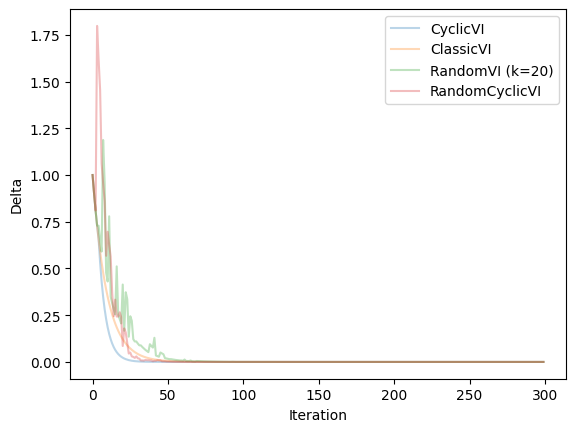

In [5]:
from solver import Solver, CyclicVI, ClassicVI, RandomVI, RandomCyclicVI
from game import SimpleGame, GridWorld
import matplotlib.pyplot as plt

g = GridWorld(5)
# g = SimpleGame()


iterators = [CyclicVI(), ClassicVI(), RandomVI(k=20), RandomCyclicVI(k=20)]#[RandomVI(k=k) for k in range(1, 26, 5)]

for iterator in iterators:
    solver = Solver(iterator, g, 0.9)
    solver.solve(steps = 300)
    solver.plot_delta()

plt.legend()
plt.show()

In [7]:

# Initialize Markov Decision Process model
actions = (0, 1)  # actions (0=left, 1=right)
states = (0, 1, 2, 3, 4)  # states (tiles)
rewards = [-1, -1, 10, -1, -1]  # Direct rewards per state
gamma = 0.9  # discount factor
# Transition probabilities per state-action pair
probs = [
    [[0.9, 0.1], [0.1, 0.9], [0, 0], [0, 0], [0, 0]],
    [[0.9, 0.1], [0, 0], [0.1, 0.9], [0, 0], [0, 0]],
    [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],  # Terminating state (all probs 0)
    [[0, 0], [0, 0], [0.9, 0.1], [0, 0], [0.1, 0.9]],
    [[0, 0], [0, 0], [0, 0], [0.9, 0.1], [0.1, 0.9]],
]

# Set value iteration parameters
max_iter = 10000  # Maximum number of iterations
delta = 1e-400  # Error tolerance
V = [0, 0, 0, 0, 0]  # Initialize values
pi = [None, None, None, None, None]  # Initialize policy


# Start value iteration
for i in range(max_iter):
    max_diff = 0  # Initialize max difference
    V_new = [0, 0, 0, 0, 0]  # Initialize values
    for s in states:
        max_val = 0
        for a in actions:

            # Compute state value
            val = rewards[s]  # Get direct reward
            for s_next in states:
                val += probs[s][s_next][a] * (
                    gamma * V[s_next]
                )  # Add discounted downstream values

            # Store value best action so far
            max_val = max(max_val, val)

            # Update best policy
            if V[s] < val:
                pi[s] = actions[a]  # Store action with highest value

        V_new[s] = max_val  # Update value with highest value

        # Update maximum difference
        max_diff = max(max_diff, abs(V[s] - V_new[s]))

    # Update value functions
    V = V_new

    # If diff smaller than threshold delta for all states, algorithm terminates
    if max_diff < delta:
        break

print(pi)

[1, 1, 1, 0, 0]


In [3]:
"""
MDPSolver:

Model/MDP
Iteration Method

Iterate until end

"""

"""
Iteration method:
Classic VI,
Random VI
Cyclic VI,
Random Cyclic VI

All iteration methods:
Take states, actions, rewards, gamma, initial values

Ouptuts
new values vector for each state
"""


"""class MDP:


    def iterate(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_random_VI(self, k):
        states = random.sample(self.states, k)

        for state in self.states:
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_cyclic_VI(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


    def iterate_cyclic_VI_random(self):
        # Get stored values
        for state in random.sample(self.states):
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


"""

'class MDP:\n\n\n    def iterate(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_random_VI(self, k):\n        states = random.sample(self.states, k)\n\n        for state in self.states:\n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_cyclic_VI(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action

In [ ]:
class MDP(ABC):
    def __init__(self, states):
        self.states = states

    @abstractmethod
    def prob(self, s, a):
        pass

    @abstractmethod
    def reward(self, s, a):
        pass

    @abc.abstractproperty
    def states(self):
        pass

